In [114]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
 
#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

In [46]:
# Using write.csv in R, I exported the dataset from package 'ISLR' to a csv file
df = pd.read_csv('Data/Wage.csv')
df.head(3)

   Unnamed: 0  year  age      sex            maritl      race  \
0      231655  2006   18  1. Male  1. Never Married  1. White   
1       86582  2004   24  1. Male  1. Never Married  1. White   
2      161300  2003   45  1. Male        2. Married  1. White   

         education              region        jobclass          health  \
0     1. < HS Grad  2. Middle Atlantic   1. Industrial       1. <=Good   
1  4. College Grad  2. Middle Atlantic  2. Information  2. >=Very Good   
2  3. Some College  2. Middle Atlantic   1. Industrial       1. <=Good   

  health_ins   logwage        wage  
0      2. No  4.318063   75.043154  
1      2. No  4.255273   70.476020  
2     1. Yes  4.875061  130.982177  

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 13 columns):
Unnamed: 0    3000 non-null int64
year          3000 non-null int64
age           3000 non-null int64
sex           3000 non-null object
maritl        3000 non-null object
race          3000 non-null object
education     3000 non-null object
region        3000 non-null object
jobclass      3000 non-null object
health        3000 non-null object
health_ins    3000 non-null object
logwage       3000 non-null float64
wage          3000 non-null float64
dtypes: float64(2), int64(3), object(8)
memory usage: 234.4+ KB


## Lab

### § 7.8.1 Polynomial Regression and Step Functions

Create polynomials for 'age'.

In [91]:
X1 = PolynomialFeatures(1).fit_transform(df.age.reshape(-1,1))
X2 = PolynomialFeatures(2).fit_transform(df.age.reshape(-1,1))
X3 = PolynomialFeatures(3).fit_transform(df.age.reshape(-1,1))
X4 = PolynomialFeatures(4).fit_transform(df.age.reshape(-1,1))
X5 = PolynomialFeatures(5).fit_transform(df.age.reshape(-1,1))

y = (df.wage > 250).map({False:0, True:1}).as_matrix()
print('X4:\n', X4[:5])
print('y:\n', y[:5])

X4:
 [[      1      18     324    5832  104976]
 [      1      24     576   13824  331776]
 [      1      45    2025   91125 4100625]
 [      1      43    1849   79507 3418801]
 [      1      50    2500  125000 6250000]]
y:
 [0 0 0 0 0]


Coefficients of the linear model. (Degree 4)

In [112]:
fit2 = sm.GLS(df.wage, X4).fit()
fit2.summary().tables[1]

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
const,-184.1542,60.040,-3.067,0.002,-301.879 -66.430
x1,21.2455,5.887,3.609,0.000,9.703 32.788
x2,-0.5639,0.206,-2.736,0.006,-0.968 -0.160
x3,0.0068,0.003,2.221,0.026,0.001 0.013
x4,-3.204e-05,1.64e-05,-1.952,0.051,-6.42e-05 1.45e-07


Selecting a suitable degree for the polynomial of age.

In [94]:
fit_1 = fit = sm.GLS(df.wage, X1).fit()
fit_2 = fit = sm.GLS(df.wage, X2).fit()
fit_3 = fit = sm.GLS(df.wage, X3).fit()
fit_4 = fit = sm.GLS(df.wage, X4).fit()
fit_5 = fit = sm.GLS(df.wage, X5).fit()

In [105]:
sm.stats.anova_lm(fit_1, fit_2, fit_3, fit_4, fit_5, typ=1)

   df_resid             ssr  df_diff        ss_diff           F        Pr(>F)
0      2998  5022216.104743        0            NaN         NaN           NaN
1      2997  4793430.094614        1  228786.010129  143.593107  2.363850e-32
2      2996  4777674.400950        1   15755.693664    9.888756  1.679202e-03
3      2995  4771604.248826        1    6070.152124    3.809813  5.104620e-02
4      2994  4770321.685810        1    1282.563017    0.804976  3.696820e-01

In [106]:
X = X4

Scikit-learn implements a regularized logistic regression model, so in this case we use GLM implementation from statsmodels.

In [107]:
glm = sm.GLM(y, X, family=sm.families.Binomial(sm.families.links.logit))
res = glm.fit()

In [113]:
# Create array of test data. Transform to polynomial degree 4.
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)

X_test = PolynomialFeatures(4).fit_transform(age_grid)
X_test[:5]

array([[     1,     18,    324,   5832, 104976],
       [     1,     19,    361,   6859, 130321],
       [     1,     20,    400,   8000, 160000],
       [     1,     21,    441,   9261, 194481],
       [     1,     22,    484,  10648, 234256]])

In [109]:
pred = res.predict(X_test)

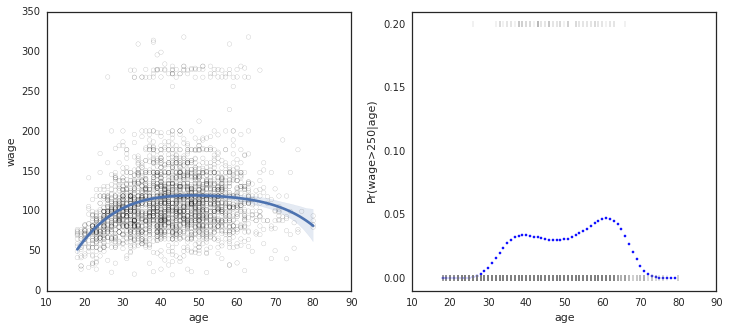

In [124]:
# creating plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
sns.regplot(df.age, df.wage, order = 4, truncate=True, scatter=False, ax=ax1)
ax1.set_ylim(ymin=0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.scatter(np.arange(df.age.min(), df.age.max()).reshape(-1,1), pred, color='b', s=5)

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)')